# The HTRC extracted feature data

Ok, so - the history of "literature." As a starting point, I decided to do experiment with the Hathi Trust "extracted features" data set, which is attractive in this context for a couple of reasons. First, it's huge - just shy of 5M volumes, and, in theory, we could eventually get our hands on the other ~10M volumes at Illinois. Second, it's a broad mix of texts - it's essentially a huge digital bookshelf hauled in out of the stacks in the library - fiction, nonfiction, periodicals, reference texts, everything under the sun. I think this is good for this project, since, in a sense, just looking at the word "literature" _in_ literature would arguably box us into a very particular type of usage - the text-within-the-text, literature thinking about itself. Which could be interesting in and of itself, but possibly not a great place to start for a general treatment of the question.

The Hathi data looks like this:

```json
{
  "id": "aeu.ark:/13960/t0000d036",
  "metadata": {
    "pubDate": "1878",
    "handleUrl": "http://hdl.handle.net/2027/aeu.ark:/13960/t0000d036",
    "language": "eng",
    "imprint": "[s.n.], 1878.",
    "htBibUrl": "http://catalog.hathitrust.org/api/volumes/full/htid/aeu.ark:/13960/t0000d036.json",
    "oclc": "716097827",
    "schemaVersion": "1.2",
    "dateCreated": "2015-02-12T20:51",
    "title": "Amphioxus and Ascidian our gelatinous ancestors"
  },
  "features": {
    "pageCount": 6,
    "pages": [
      {
        "tokenCount": 312,
        "languages": [
          {
            "en": "1.00"
          }
        ],
        "header": {
          "tokenPosCount": {},
          "tokenCount": 0,
          "emptyLineCount": 0,
          "sentenceCount": 0,
          "lineCount": 0
        },
        "seq": "00000001",
        "body": {
          "tokenPosCount": {
            "presence": {
              "NN": 1
            },
            "kind": {
              "NN": 1
            },
            "investigations": {
              "NNS": 1
            },
            "vertebraie": {
              "NN": 1
            },
            "wise": {
              "JJ": 1
            },
            "series": {
              "NN": 1
            },
            "177*.": {
              "VBG": 1
            },
            "the": {
              "DT": 10
            },
            "Vertebrata": {
              "NNP": 1
            },
            "Past": {
              "NNP": 1
            },
            "he": {
              "PRP": 2
            },
            "mean": {
              "VBP": 1
            },
            "far-searching": {
              "JJ": 1
            },
            "ado": {
              "NN": 1
            },
            "(": {
              "-LRB-": 1
            },
            "tender": {
              "VB": 1
            },
            "of": {
              "IN": 9
            },

            // more words...
            
          },
          "tokenCount": 312,
          "emptyLineCount": 20,
          "sentenceCount": 15,
          "lineCount": 66
        },
        "footer": {
          "tokenPosCount": {},
          "tokenCount": 0,
          "emptyLineCount": 0,
          "sentenceCount": 0,
          "lineCount": 0
        },
        "emptyLineCount": 20,
        "sentenceCount": 15,
        "lineCount": 66
      },
      
      // more pages...
      
    ],
    "schemaVersion": "2.0",
    "dateCreated": "2015-02-19T17:21"
  }
}

```

Basically - simple bibliographic metadata about the volume, and then per-page token counts, broken out by page section and part-of-speech. I actually think that the "page" is a nice unit of study for this projet, in a lot of ways. As discussed at the Concept Lab meeting this week - this scale is a nice middle-ground between the tight scope of the "sentence" or "phrase," the unit of analysis for the traditional notion of colocation in corpus linguistics, and the broader notion of the "document," as used in bag-of-words paradigms like topic modeling or information retrieval. It's a small constituent part of a text, but still big enough to lasso a meaningful swath of semantic information.

## Data wrangling

So, where to start? To say anything meaningful about changes in word frequencies over time around "literature," we have to be able to compare against the baseline changes in volume over time, or else we'd almost certainly just be picking up on these overall trends. Eg - words like "thou" or "magick" show up much less frequently around literature over time in an absolute sense, but this is just because they become generally less prevalent, not because of any real change in the conceptual attraction of the words.

What we need, then, is per-year token counts for each unique token in the corpus. This is simple in concept - just loop through the volumes and build up a big `year -> token -> count` map. But in practice, because of the size of the Hathi data, this gets complicated, especially if we want to write code that will scale up to the complete data set. The volumes are stored as `.bz2` JSON files, which means that they need to be inflated on-the-fly during extraction runs, which is very slow. (But, Ted Underwood advises against trying to pre-extract the volumes, which more than doubles the ~2TB footprint of the corpus.) Then there's the question of how to store the counts. It becomes unweildy to just cake up Python dictionaries with many (tens of) millions of keys in RAM, and, even if it fits - what then? Just compute against it as a raw data structure? Dump it off as a huge, many-gigabyte JSON file, load it back into memory every time? Lots of surface area for failure and headache there. Work at this scale calls out for some kind of real data store, but this leads to performance problems beacause there's always a significant indexing overhead if you shovel data into Postgres, Redis, etc.

After a bit of experimentation, here's the flow I settled on:

- Loop through the volume paths in groups of 5-10k. For each successive group, use Python's `multiprocessing` module to spawn off a pool of workers that process the paths in parallel - inflate the `.bz2`, make a `Volume` instance, and return a cleaned `token -> count` map for the volume. Since reading the files is heavy IO, the parallelization gives a huge speedup.


- As these results come back to the controller process, build up an in-memory cache of the `year -> token -> count` totals.


- Only when all the paths in the group have been processed, flush the cached counts into Postgres using the new `UPSERT` syntax in 9.5, which makes it possible to increment each of the year + token counters with a single query.


- Empty the cache, repeat with the next group of paths.

Why the "groups", instead of just processing and indexing each volume individually? This has the effect of bundling together the increment queries, which reduces the number of times we have to go across the wire to Postgres. Eg, say three volumes produce these token/year/count triples:

```
("literature", 1900, 10)
("literature", 1900, 20)
("literature", 1900, 30)
```

Instead of running three separate queries, by building up the temporary caches in-memory these get merged into a single update that has the same effect:

```
("literature", 1900, 60)
```

But, since we flush the cache after each ~10k volumes, we never build up too much memory pressure on the machine.

## Counting words

The word counts are generated and accessed via the `Count` class, a SQLAlchemy model. To get an ordered list of years (our X-axis):

In [1]:
from htrc.models import Count

years = Count.years()
print(years[:50])

[1635, 1656, 1705, 1713, 1714, 1715, 1716, 1752, 1753, 1754, 1756, 1763, 1764, 1774, 1780, 1783, 1784, 1785, 1787, 1789, 1790, 1793, 1795, 1797, 1798, 1800, 1801, 1803, 1804, 1809, 1810, 1812, 1813, 1815, 1816, 1817, 1818, 1819, 1820, 1821, 1822, 1823, 1824, 1826, 1827, 1828, 1830, 1831, 1832, 1833]


To get a sorted list of unique tokens (so we can iterate over all observed words):

In [2]:
tokens = Count.tokens()
print(tokens[:50])

['a', 'abandoned', 'ability', 'able', 'about', 'above', 'abroad', 'absence', 'absolute', 'absolutely', 'abstract', 'abuse', 'academic', 'academy', 'accept', 'acceptable', 'accepted', 'access', 'accident', 'accompanied', 'accomplished', 'according', 'account', 'accounts', 'accurate', 'accused', 'achieve', 'achieved', 'achievement', 'acid', 'acquired', 'across', 'act', 'acting', 'action', 'actions', 'active', 'activities', 'activity', 'actor', 'actors', 'actress', 'acts', 'actual', 'actually', 'ad', 'adam', 'adams', 'add', 'added']


Now, the basic count data. To get the total number of tokens observed in a given year:

In [3]:
Count.year_count(1912)

156144

And, to get the number of times that word X appeared in year Y:

In [4]:
Count.token_year_count('literature', 1912)

36

This gives us what we need for aggregate time-series plots. Here's total volume by year:

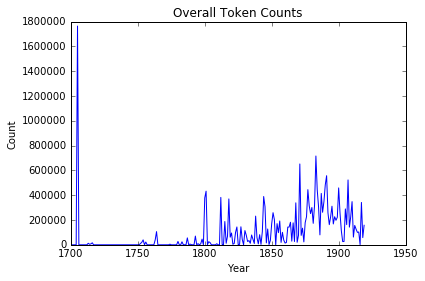

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt

xs = range(1700, 1920)

ys = []
for year in xs:
    ys.append(Count.year_count(year))
    
plt.title('Overall Token Counts')
plt.xlabel('Year')
plt.ylabel('Count')
plt.plot(xs, ys)

Or, for an individual token:

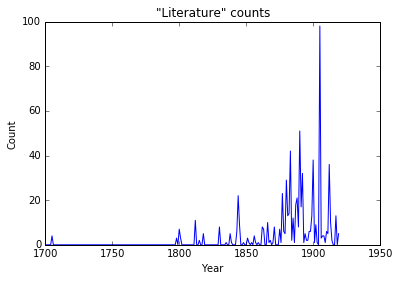

In [6]:
ys = []
for year in xs:
    ys.append(Count.token_year_count('literature', year))
    
plt.title('"Literature" counts')
plt.xlabel('Year')
plt.ylabel('Count')
plt.plot(xs, ys)

Or, more helpfully - expressed as words-per-million, scaling for the overall volume:

In [ ]:
ys = []
for year in xs:
    ys.append(Count.token_year_wpm('literature', year))
    
plt.title('"Literature" counts')
plt.xlabel('Year')
plt.ylabel('Words per million')
plt.plot(xs, ys)